## Import Libraries & Setup

In [40]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.4.2
Uninstalling matplotlib-3.4.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.2
     |████████████████████████████████| 13.1 MB 3.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12

In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    ! git clone https://github.com/salesforce/warp-drive.git
    % cd warp-drive
    ! pip install -e .
else:
    ! pip install rl_warp_drive

Cloning into 'warp-drive'...
remote: Enumerating objects: 616, done.
remote: Counting objects: 100% (616/616), done.
remote: Compressing objects: 100% (403/403), done.
remote: Total 616 (delta 337), reused 461 (delta 210), pack-reused 0
Receiving objects: 100% (616/616), 7.57 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (337/337), done.
/content/warp-drive
Obtaining file:///content/warp-drive
     |████████████████████████████████| 1.5 MB 8.7 MB/s 
     |████████████████████████████████| 10.3 MB 73.5 MB/s 
     |████████████████████████████████| 1.7 MB 47.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 280 kB 51.5 MB/s 
     |████████████████████████████████| 596 kB 39.5 MB/s 
     |████████████████████████████████| 831.4 MB 2.5 kB/s 
     |████████████████████████████████| 66 kB 5.9 MB/s 
     |████████████████████████████████| 75 kB 5.6 MB/s 
  Created whee

In [ ]:
import warp_drive
import numpy as np
import torch
import json

from timeit import Timer
from gym.spaces import Discrete, MultiDiscrete
from IPython.display import HTML
from example_envs.tag_continuous.tag_continuous import TagContinuous
from warp_drive.env_wrapper import EnvWrapper
from warp_drive.managers.data_manager import CUDADataManager
from warp_drive.managers.function_manager import CUDAFunctionManager, CUDASampler
from warp_drive.managers.data_manager import CUDADataManager
from warp_drive.training.models.fully_connected import FullyConnected
from warp_drive.training.trainer import Trainer
from warp_drive.training.utils.data_loader import create_and_push_data_placeholders
from warp_drive.utils.data_feed import DataFeed
from warp_drive.utils.constants import Constants
from warp_drive.utils.data_feed import DataFeed
from warp_drive.utils.common import get_project_root
from warp_drive.env_wrapper import EnvWrapper

from tutorials.utils.generate_rollout_animation import generate_env_rollout_animation

from warp_drive.managers.function_manager import (
    CUDAFunctionManager,
    CUDALogController,
    CUDASampler,
    CUDAEnvironmentReset,
)

pytorch_cuda_init_success = torch.cuda.FloatTensor(8)
_CUBIN_FILEPATH = f"{get_project_root()}/warp_drive/cuda_bin"
_ACTIONS = Constants.ACTIONS

#Data Manager - To handle all the data transfers between the host and the device
#Function Manager - To load the CUDA programs and execute

In [ ]:
num_agents = 3
num_envs = 2
episode_length = 5

cuda_data_manager = CUDADataManager(num_agents, num_envs, episode_length)


Pushing data to device...
- _log_mask_                                                                      : dtype=int32     , shape=(6,)

Pushing data to device...
- _done_                                                                          : dtype=int32     , shape=(2,)

Pushing data to device...
- _timestep_                                                                      : dtype=int32     , shape=(2,)


In [ ]:
random_data = np.random.rand(num_envs, num_agents)

In [ ]:
random_data

array([[1.09240327e-01, 1.71375346e-01, 4.72166432e-04],
       [4.16486810e-01, 7.08498756e-03, 6.47334382e-01]])

# Push and pull data from host (CPU) to device (GPU)

In [ ]:
data_feed = DataFeed()
data_feed.add_data(
    name="random_data",
    data=random_data,
    save_copy_and_apply_at_reset=False,
    log_data_across_episode=False,
)

In [ ]:
data_feed

{'random_data': {'attributes': {'log_data_across_episode': False,
   'save_copy_and_apply_at_reset': False},
  'data': array([[1.09240327e-01, 1.71375346e-01, 4.72166432e-04],
         [4.16486810e-01, 7.08498756e-03, 6.47334382e-01]])}}

In [ ]:
cuda_data_manager.push_data_to_device(data_feed)


Pushing data to device...
[WARNING]: CUDADataManager casts the data 'random_data' from type float64 to float32
- random_data                                                                     : dtype=float32   , shape=(2, 3)


In [ ]:
data_fetched_from_device = cuda_data_manager.pull_data_from_device("random_data")

In [ ]:
data_fetched_from_device

array([[1.0924032e-01, 1.7137535e-01, 4.7216643e-04],
       [4.1648680e-01, 7.0849876e-03, 6.4733440e-01]], dtype=float32)

In [ ]:
tensor_feed = DataFeed()
tensor_feed.add_data(name="random_tensor", data=random_data)

cuda_data_manager.push_data_to_device(tensor_feed, torch_accessible=True)


Pushing data to device...
[WARNING]: CUDADataManager casts the data 'random_tensor' from type float64 to float32
- random_tensor                                                                   : dtype=float32   , shape=(2, 3)


In [ ]:
tensor_on_device = cuda_data_manager.data_on_device_via_torch("random_tensor")

# Time comparison for data pull ("torch_accessible` True versus False)

In [ ]:
large_array = np.random.rand(1000, 1000)

In [ ]:
data_feed = DataFeed()
data_feed.add_data(
    name="large_array",
    data=large_array,
)
cuda_data_manager.push_data_to_device(data_feed, torch_accessible=False)


Pushing data to device...
[WARNING]: CUDADataManager casts the data 'large_array' from type float64 to float32
- large_array                                                                     : dtype=float32   , shape=(1000, 1000)


In [ ]:
Timer(lambda: cuda_data_manager.pull_data_from_device("large_array")).timeit(
    number=1000
)

1.318469590999939

In [ ]:
data_feed = DataFeed()
data_feed.add_data(
    name="large_array_torch",
    data=large_array,
)
cuda_data_manager.push_data_to_device(data_feed, torch_accessible=True)


Pushing data to device...
[WARNING]: CUDADataManager casts the data 'large_array_torch' from type float64 to float32
- large_array_torch                                                               : dtype=float32   , shape=(1000, 1000)


In [ ]:
Timer(lambda: cuda_data_manager.data_on_device_via_torch("random_tensor")).timeit(1000)

0.00040619100002459163

In [ ]:
cuda_function_manager = CUDAFunctionManager(
    num_agents=cuda_data_manager.meta_info("n_agents"),
    num_envs=cuda_data_manager.meta_info("n_envs"),
)

In [ ]:
source_code = """
// A function to demonstrate how to manipulate data on the GPU.
// This function increments each the random data array we pushed to the GPU before.
// Each index corresponding to (env_id, agent_id) in the array is incremented by "agent_id + env_id".
// Everything inside the if() loop runs in parallel for each agent and environment.
//
extern "C"{
    __global__ void cuda_increment(                               
            float* data,                                  
            int num_agents                                       
    )                                                            
    {                                                            
        int env_id = blockIdx.x;                                 
        int agent_id = threadIdx.x;                             
        if (agent_id < num_agents){                              
            int array_index = env_id * num_agents + agent_id;
            int increment = env_id + agent_id;
            data[array_index] += increment;
        }                                                            
    }   
}
"""

In [ ]:
cuda_function_manager.load_cuda_from_source_code(
    source_code, default_functions_included=False
)
cuda_function_manager.initialize_functions(["cuda_increment"])

Successfully build and load the source code
starting to load the cuda kernel function: cuda_increment from the CUDA module 
finished loading the cuda kernel function: cuda_increment from the CUDA module, 


In [ ]:
increment_function = cuda_function_manager.get_function("cuda_increment")

In [ ]:
cuda_data_manager.push_data_to_device(
    {
        "num_agents": {
            "data": num_agents,
            "attributes": {
                "save_copy_and_apply_at_reset": False,
                "log_data_across_episode": False,
            },
        }
    }
)


Pushing data to device...
- num_agents                                                                      : dtype=int32     , shape=()


In [ ]:
increment_function(
    cuda_data_manager.device_data("random_data"),
    cuda_data_manager.device_data("num_agents"),
    block=cuda_function_manager.block,
    grid=cuda_function_manager.grid,
)

In [ ]:
random_data

array([[1.09240327e-01, 1.71375346e-01, 4.72166432e-04],
       [4.16486810e-01, 7.08498756e-03, 6.47334382e-01]])

In [ ]:
cuda_data_manager.pull_data_from_device("random_data")

array([[0.10924032, 1.1713754 , 2.000472  ],
       [1.4164867 , 2.007085  , 3.6473343 ]], dtype=float32)

In [ ]:
cuda_data_manager.pull_data_from_device("random_data") - random_data

array([[-3.72355036e-09,  1.00000005e+00,  1.99999990e+00],
       [ 9.99999930e-01,  2.00000010e+00,  2.99999995e+00]])

In [ ]:
increment_function(
    cuda_data_manager.device_data("random_data"),
    cuda_data_manager.device_data("num_agents"),
    block=cuda_function_manager.block,
    grid=cuda_function_manager.grid,
)
cuda_data_manager.pull_data_from_device("random_data") - random_data

array([[-3.72355036e-09,  1.99999993e+00,  3.99999990e+00],
       [ 1.99999993e+00,  3.99999986e+00,  5.99999972e+00]])

In [ ]:
def push_random_data_and_increment_timer(
    num_runs=1,
    num_envs=2,
    num_agents=3,
    source_code=None,
    episode_length=100,
):

    assert source_code is not None

    # Initialize the CUDA data manager
    cuda_data_manager = CUDADataManager(
        num_agents=num_agents, num_envs=num_envs, episode_length=episode_length
    )

    # Initialize the CUDA function manager
    cuda_function_manager = CUDAFunctionManager(
        num_agents=cuda_data_manager.meta_info("n_agents"),
        num_envs=cuda_data_manager.meta_info("n_envs"),
    )

    # Load source code and initialize function
    cuda_function_manager.load_cuda_from_source_code(
        source_code, default_functions_included=False
    )
    cuda_function_manager.initialize_functions(["cuda_increment"])
    increment_function = cuda_function_manager.get_function("cuda_increment")

    def push_random_data(num_agents, num_envs):
        # Create random data
        random_data = np.random.rand(num_envs, num_agents)

        # Push data from host to device
        data_feed = DataFeed()
        data_feed.add_data(
            name="random_data",
            data=random_data,
        )
        data_feed.add_data(name="num_agents", data=num_agents)
        cuda_data_manager.push_data_to_device(data_feed)

    def increment_data():
        increment_function(
            cuda_data_manager.device_data("random_data"),
            cuda_data_manager.device_data("num_agents"),
            block=cuda_function_manager.block,
            grid=cuda_function_manager.grid,
        )

    # One-time data push
    data_push_time = Timer(lambda: push_random_data(num_agents, num_envs)).timeit(
        number=1
    )
    # Increment the arrays 'num_runs' times
    program_run_time = Timer(lambda: increment_data()).timeit(number=num_runs)

    return {"data push times": data_push_time, "code run time": program_run_time}

In [ ]:
%%capture

num_runs = 10000
times = {}

for scenario in [
    (1, 1),
    (1, 10),
    (1, 100),
    (10, 10),
    (1, 1000),
    (100, 100),
    (1000, 1000),
]:
    num_envs, num_agents = scenario
    times.update(
        {
            f"envs={num_envs}, agents={num_agents}": push_random_data_and_increment_timer(
                num_runs, num_envs, num_agents, source_code
            )
        }
    )

In [ ]:
print(f"Times for {num_runs} function calls")
print("*" * 40)
for key, value in times.items():
    print(
        f"{key:30}: data push time: {value['data push times']:10.5}s,\t mean increment times: {value['code run time']:10.5}s"
    )

Times for 10000 function calls
****************************************
envs=1, agents=1              : data push time: 0.00025336s,	 mean increment times:   0.096586s
envs=1, agents=10             : data push time: 0.00016682s,	 mean increment times:    0.09655s
envs=1, agents=100            : data push time:  0.0001955s,	 mean increment times:    0.10029s
envs=10, agents=10            : data push time:  0.0002714s,	 mean increment times:    0.10875s
envs=1, agents=1000           : data push time:   0.000159s,	 mean increment times:   0.095124s
envs=100, agents=100          : data push time: 0.00027643s,	 mean increment times:   0.096161s
envs=1000, agents=1000        : data push time:    0.01249s,	 mean increment times:   0.099531s


In [3]:
run_config = dict(
    name="tag_continuous",
    # Environment settings
    env=dict(
        num_taggers=5,
        num_runners=20,
        episode_length=100,
        seed=1234,
        use_full_observation=False,
        num_other_agents_observed=10,
        tagging_distance=0.02,
    ),
    # Trainer settings
    trainer=dict(
        num_envs=100,  # Number of environment replicas (numbre of GPU blocks used)
        train_batch_size=10000,  # total batch size used for training per iteration (across all the environments)
        num_episodes=5000,  # Total number of episodes to run the training for (can be arbitrarily high!)
        algorithm="A2C",  # trainer algorithm
        vf_loss_coeff=1,  # loss coefficient for the value function loss
        entropy_coeff=0.05,  # coefficient for the entropy component of the loss
        clip_grad_norm=True,  # fla indicating whether to clip the gradient norm or not
        max_grad_norm=0.5,  # when clip_grad_norm is True, the clip level
        normalize_advantage=False,  # flag indicating whether to normalize advantage or not
        normalize_return=False,  # flag indicating whether to normalize return or not
    ),
    # Policy network settings
    policy=dict(
        runner=dict(
            to_train=True,
            name="fully_connected",
            gamma=0.98,  # discount rate gamms
            lr=0.005,  # learning rate
            model=dict(
                fc_dims=[
                    256,
                    256,
                ],  # dimension(s) of the fully connected layers as a list
                model_ckpt_filepath="",  # load model parameters from a saved checkpoint (if specified)
            ),
        ),
        tagger=dict(
            to_train=True,
            name="fully_connected",
            gamma=0.98,
            lr=0.002,
            model=dict(fc_dims=[256, 256], model_ckpt_filepath=""),
        ),
    ),
    # Checkpoint saving setting
    saving=dict(
        metrics_log_freq=10,  # How often (in iterations) to print the metrics
        model_params_save_freq=5000,  # How often (in iterations) to save the model parameters
        basedir="/tmp",  # base folder used for saving
        name="continuous_tag",
        tag="example",
    ),
)

In [4]:
# Create a wrapped environment object via the EnvWrapper
# Ensure that use_cuda is set to True (in order to run on the GPU)
env_wrapper = EnvWrapper(
    TagContinuous(**run_config["env"]),
    num_envs=run_config["trainer"]["num_envs"],
    use_cuda=True,
)

# Agents can share policy models: this dictionary maps policy model names to agent ids.
policy_tag_to_agent_id_map = {
    "tagger": list(env_wrapper.env.taggers),
    "runner": list(env_wrapper.env.runners),
}

# Create the trainer object
trainer = Trainer(
    env_wrapper=env_wrapper,
    config=run_config,
    policy_tag_to_agent_id_map=policy_tag_to_agent_id_map,
)

# Perform training!
trainer.train()

# Shut off gracefully
trainer.graceful_close()

USING CUDA...
Initializing the CUDA data manager...

Pushing data to device...
- _log_mask_                                                                      : dtype=int32     , shape=(101,)

Pushing data to device...
- _done_                                                                          : dtype=int32     , shape=(100,)

Pushing data to device...
- _timestep_                                                                      : dtype=int32     , shape=(100,)
Initializing the CUDA function manager...
Using cubin_filepath: /content/warp-drive/warp_drive/cuda_bin
Find the targeting environment source code from the default environment directory: /content/warp-drive/example_envs/tag_continuous/tag_continuous_step.cu
Building the targeting environment with source code at: /content/warp-drive/example_envs/tag_continuous/tag_continuous_step.cu
header file /content/warp-drive/warp_drive/cuda_includes/env_config.h has num_agents: 25 and num_envs: 100 that are consistent with the b

In [6]:
cuda_data_manager = CUDADataManager(num_agents=5, episode_length=10, num_envs=2)
cuda_function_manager = CUDAFunctionManager(
    num_agents=cuda_data_manager.meta_info("n_agents"),
    num_envs=cuda_data_manager.meta_info("n_envs"),
)
cuda_function_manager.load_cuda_from_binary_file(
    f"{_CUBIN_FILEPATH}/test_build.fatbin", default_functions_included=True
)
cuda_sampler = CUDASampler(function_manager=cuda_function_manager)
cuda_sampler.init_random(seed=None)


Pushing data to device...
- _log_mask_                                                                      : dtype=int32     , shape=(11,)

Pushing data to device...
- _done_                                                                          : dtype=int32     , shape=(2,)

Pushing data to device...
- _timestep_                                                                      : dtype=int32     , shape=(2,)
Successfully load the cubin_file from /content/warp-drive/warp_drive/cuda_bin/test_build.fatbin
starting to load the cuda kernel function: reset_log_mask from the CUDA module 
finished loading the cuda kernel function: reset_log_mask from the CUDA module, 
starting to load the cuda kernel function: update_log_mask from the CUDA module 
finished loading the cuda kernel function: update_log_mask from the CUDA module, 
starting to load the cuda kernel function: log_one_step_in_float from the CUDA module 
finished loading the cuda kernel function: log_one_step_in_float from th

In [7]:
data_feed = DataFeed()
data_feed.add_data(name=f"{_ACTIONS}_a", data=[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
cuda_data_manager.push_data_to_device(data_feed, torch_accessible=True)
assert cuda_data_manager.is_data_on_device_via_torch(f"{_ACTIONS}_a")


Pushing data to device...
[WARNING]: CUDADataManager casts the data 'sampled_actions_a' from type int64 to int32
- sampled_actions_a                                                               : dtype=int32     , shape=(2, 5)


In [8]:
cuda_sampler.register_actions(
    cuda_data_manager, action_name=f"{_ACTIONS}_a", num_actions=3
)

distribution = np.array(
    [
        [
            [0.333, 0.333, 0.333],
            [0.2, 0.5, 0.3],
            [0.95, 0.02, 0.03],
            [0.02, 0.95, 0.03],
            [0.02, 0.03, 0.95],
        ],
        [
            [0.1, 0.7, 0.2],
            [0.7, 0.2, 0.1],
            [0.5, 0.5, 0.0],
            [0.0, 0.5, 0.5],
            [0.5, 0.0, 0.5],
        ],
    ]
)
distribution = torch.from_numpy(distribution).float().cuda()


Pushing data to device...
- sampled_actions_a_cum_distr                                                     : dtype=float32   , shape=(2, 5, 3)


In [9]:
# Run 10000 times to collect statistics
actions_batch = torch.from_numpy(np.empty((10000, 2, 5), dtype=np.int32)).cuda()

for i in range(10000):
    cuda_sampler.sample(cuda_data_manager, distribution, action_name=f"{_ACTIONS}_a")
    actions_batch[i] = cuda_data_manager.data_on_device_via_torch(f"{_ACTIONS}_a")
actions_batch_host = actions_batch.cpu().numpy()

In [10]:
actions_env_0 = actions_batch_host[:, 0]
actions_env_1 = actions_batch_host[:, 1]

In [11]:
print(
    "Sampled actions distribution versus the given distribution (in bracket) for env 0: \n"
)
for agent_id in range(5):
    print(
        f"Sampled action distribution for agent_id: {agent_id}:\n"
        f"{(actions_env_0[:, agent_id] == 0).sum() / 10000.0}({distribution[0, agent_id, 0]}), \n"
        f"{(actions_env_0[:, agent_id] == 1).sum() / 10000.0}({distribution[0, agent_id, 1]}), \n"
        f"{(actions_env_0[:, agent_id] == 2).sum() / 10000.0}({distribution[0, agent_id, 2]})  \n"
    )

Sampled actions distribution versus the given distribution (in bracket) for env 0: 

Sampled action distribution for agent_id: 0:
0.3377(0.3330000042915344), 
0.3286(0.3330000042915344), 
0.3337(0.3330000042915344)  

Sampled action distribution for agent_id: 1:
0.2014(0.20000000298023224), 
0.4929(0.5), 
0.3057(0.30000001192092896)  

Sampled action distribution for agent_id: 2:
0.949(0.949999988079071), 
0.0194(0.019999999552965164), 
0.0316(0.029999999329447746)  

Sampled action distribution for agent_id: 3:
0.02(0.019999999552965164), 
0.9489(0.949999988079071), 
0.0311(0.029999999329447746)  

Sampled action distribution for agent_id: 4:
0.0233(0.019999999552965164), 
0.0282(0.029999999329447746), 
0.9485(0.949999988079071)  



In [12]:
print(
    "Sampled actions distribution versus the given distribution (in bracket) for env 1: "
)

for agent_id in range(5):
    print(
        f"Sampled action distribution for agent_id: {agent_id}:\n"
        f"{(actions_env_1[:, agent_id] == 0).sum() / 10000.0}({distribution[1, agent_id, 0]}), \n"
        f"{(actions_env_1[:, agent_id] == 1).sum() / 10000.0}({distribution[1, agent_id, 1]}), \n"
        f"{(actions_env_1[:, agent_id] == 2).sum() / 10000.0}({distribution[1, agent_id, 2]})  \n"
    )

Sampled actions distribution versus the given distribution (in bracket) for env 1: 
Sampled action distribution for agent_id: 0:
0.0954(0.10000000149011612), 
0.702(0.699999988079071), 
0.2026(0.20000000298023224)  

Sampled action distribution for agent_id: 1:
0.7019(0.699999988079071), 
0.1972(0.20000000298023224), 
0.1009(0.10000000149011612)  

Sampled action distribution for agent_id: 2:
0.4999(0.5), 
0.5001(0.5), 
0.0(0.0)  

Sampled action distribution for agent_id: 3:
0.0(0.0), 
0.5013(0.5), 
0.4987(0.5)  

Sampled action distribution for agent_id: 4:
0.4996(0.5), 
0.0(0.0), 
0.5004(0.5)  



In [13]:
data_feed = DataFeed()
data_feed.add_data(name=f"{_ACTIONS}_b", data=[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
cuda_data_manager.push_data_to_device(data_feed, torch_accessible=True)
assert cuda_data_manager.is_data_on_device_via_torch(f"{_ACTIONS}_b")


Pushing data to device...
[WARNING]: CUDADataManager casts the data 'sampled_actions_b' from type int64 to int32
- sampled_actions_b                                                               : dtype=int32     , shape=(2, 5)


In [14]:
cuda_sampler.register_actions(
    cuda_data_manager, action_name=f"{_ACTIONS}_b", num_actions=4
)


Pushing data to device...
- sampled_actions_b_cum_distr                                                     : dtype=float32   , shape=(2, 5, 4)


In [15]:
distribution = np.array(
    [
        [
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
        ],
        [
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
            [0.25, 0.25, 0.25, 0.25],
        ],
    ]
)
distribution = torch.from_numpy(distribution).float().cuda()

In [16]:
# Run 10000 times to collect statistics.
actions_batch = torch.from_numpy(np.empty((10000, 2, 5), dtype=np.int32)).cuda()

for i in range(10000):
    cuda_sampler.sample(cuda_data_manager, distribution, action_name=f"{_ACTIONS}_b")
    actions_batch[i] = cuda_data_manager.data_on_device_via_torch(f"{_ACTIONS}_b")
actions_batch_host = actions_batch.cpu().numpy()

In [17]:
actions_batch_host

array([[[0, 2, 2, 3, 2],
        [0, 3, 1, 1, 3]],

       [[0, 2, 0, 2, 2],
        [1, 1, 1, 3, 3]],

       [[0, 2, 2, 0, 2],
        [3, 1, 2, 3, 2]],

       ...,

       [[1, 0, 3, 3, 2],
        [2, 2, 0, 3, 1]],

       [[1, 1, 1, 3, 0],
        [3, 3, 1, 2, 3]],

       [[2, 0, 1, 1, 3],
        [2, 1, 0, 3, 3]]], dtype=int32)

In [18]:
actions_batch_host.std(axis=2).mean(axis=0)

array([0.96500696, 0.96213711])

In [19]:
actions_batch_numpy = np.empty((10000, 2, 5), dtype=np.int32)
for i in range(10000):
    actions_batch_numpy[i, 0, :] = np.random.choice(4, 5)
    actions_batch_numpy[i, 1, :] = np.random.choice(4, 5)
actions_batch_numpy.std(axis=2).mean(axis=0)

array([0.96545725, 0.96298462])

In [20]:
from torch.distributions import Categorical

In [21]:
distribution = np.array(
    [
        [
            [0.333, 0.333, 0.333],
            [0.2, 0.5, 0.3],
            [0.95, 0.02, 0.03],
            [0.02, 0.95, 0.03],
            [0.02, 0.03, 0.95],
        ],
        [
            [0.1, 0.7, 0.2],
            [0.7, 0.2, 0.1],
            [0.5, 0.5, 0.0],
            [0.0, 0.5, 0.5],
            [0.5, 0.0, 0.5],
        ],
    ]
)
distribution = torch.from_numpy(distribution).float().cuda()

In [22]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
for _ in range(1000):
    cuda_sampler.sample(cuda_data_manager, distribution, action_name=f"{_ACTIONS}_a")
end_event.record()
torch.cuda.synchronize()
print(f"time elapsed: {start_event.elapsed_time(end_event)} ms")

time elapsed: 23.080320358276367 ms


In [23]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
for _ in range(1000):
    Categorical(distribution).sample()
end_event.record()
torch.cuda.synchronize()
print(f"time elapsed: {start_event.elapsed_time(end_event)} ms")

time elapsed: 177.00160217285156 ms


In [44]:
# Load the run config.
with open("tutorials/assets/tag_continuous_training/run_config.json") as f:
    run_config = json.load(f)

In [32]:
# Create the environment object.
env_wrapper = EnvWrapper(TagContinuous(**run_config["env"]))

In [33]:
# Define the policy tag to agent id mapping.
policy_tag_to_agent_id_map = {
    "tagger": list(env_wrapper.env.taggers),
    "runner": list(env_wrapper.env.runners),
}

In [45]:
# Step through the environment.
# The environment(s) store and update the rollout data internally in env.global_state.


def generate_rollout_inplace(env_wrapper, run_config, load_model_weights=False):
    assert env_wrapper is not None
    assert run_config is not None

    obs = env_wrapper.reset_all_envs()
    action_space = env_wrapper.env.action_space[0]

    # Instantiate the policy models.
    policy_models = {}

    for policy in policy_tag_to_agent_id_map:
        policy_config = run_config["policy"][policy]
        if policy_config["name"] == "fully_connected":
            policy_models[policy] = FullyConnected(
                env=env_wrapper,
                fc_dims=policy_config["model"]["fc_dims"],
                policy=policy,
                policy_tag_to_agent_id_map=policy_tag_to_agent_id_map,
            )
        else:
            raise NotImplementedError

    if load_model_weights:
        print(f"Loading saved weights into the policy models...")
        for policy in policy_models:
            state_dict_filepath = (
                f"tutorials/assets/tag_continuous_training/{policy}_after_training.state_dict"
            )
            policy_models[policy].load_state_dict(torch.load(state_dict_filepath))
            print(f"Loaded ckpt {state_dict_filepath} for {policy} policy model.")

    for t in range(env_wrapper.env.episode_length):
        stacked_obs = np.stack(list(obs.values())).astype(np.float32)

        # Create dict to collect the actions for all agents.
        if isinstance(action_space, Discrete):
            actions = {agent_id: 0 for agent_id in range(env_wrapper.env.num_agents)}
        elif isinstance(action_space, MultiDiscrete):
            actions = {
                agent_id: [0, 0] for agent_id in range(env_wrapper.env.num_agents)
            }
        else:
            raise NotImplementedError

        # Sample actions for all agents.
        for policy in policy_models:
            agent_ids = policy_tag_to_agent_id_map[policy]
            probabilities, vals = policy_models[policy](
                obs=torch.from_numpy(stacked_obs[agent_ids])
            )
            if isinstance(action_space, Discrete):
                for idx, probs in enumerate(probabilities):
                    sampled_actions = torch.multinomial(probs, num_samples=1)
                    for sample_action_idx, action in enumerate(sampled_actions):
                        actions[agent_ids[sample_action_idx]] = action.numpy()[0]

            elif isinstance(action_space, MultiDiscrete):
                for idx, probs in enumerate(probabilities):
                    sampled_actions = torch.multinomial(probs, num_samples=1)
                    for sample_action_idx, action in enumerate(sampled_actions):
                        actions[agent_ids[sample_action_idx]][idx] = action.numpy()[0]
            else:
                raise NotImplementedError

        # Execute actions in the environment.
        obs, rew, done, info = env_wrapper.step(actions)

        if done["__all__"]:
            break

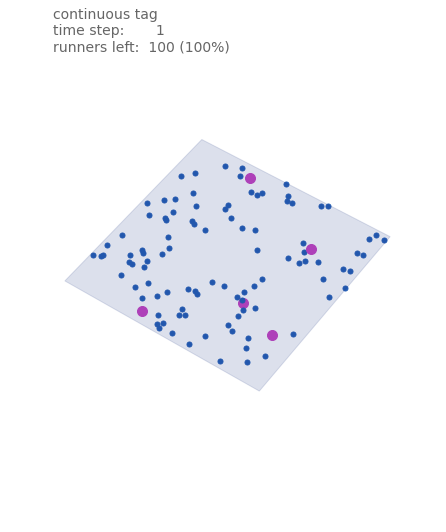

In [41]:
generate_rollout_inplace(env_wrapper, run_config)
# Visualize the env at t=0
anim = generate_env_rollout_animation(
    env_wrapper.env, i_start=1, fps=50, fig_width=6, fig_height=6
)

In [36]:
# Now, visualize the entire episode roll-out
HTML(anim.to_html5_video())

Loading saved weights into the policy models...
Loaded ckpt tutorials/assets/tag_continuous_training/tagger_after_training.state_dict for tagger policy model.
Loaded ckpt tutorials/assets/tag_continuous_training/runner_after_training.state_dict for runner policy model.


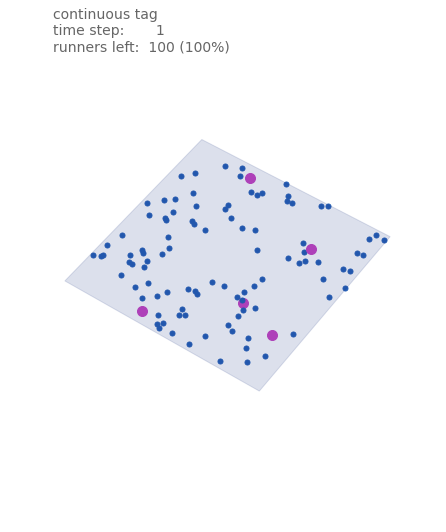

In [46]:
generate_rollout_inplace(env_wrapper, run_config, load_model_weights=True)
# Visualize the env at t=0
anim = generate_env_rollout_animation(
    env_wrapper.env, i_start=1, fps=50, fig_width=6, fig_height=6
)

In [47]:
# Now, visualize the entire episode roll-out
HTML(anim.to_html5_video())